# L4d: Kernel Regression in Finance
In this lab, we implement kernel regression, a non-parametric method for modeling smooth relationships in financial time-series data. Unlike linear models, kernel regression flexibly captures non-linear patterns by weighting nearby observations through a kernel function. This enables accurate forecasting and pattern discovery without assuming a specific functional form.

> __Learning Objectives:__
> 
> By the end of this lab, you will be able to:
> 
> * __Compute growth-rate features:__ Construct return and exponential moving average (EMA) series from market data to create informative predictors for kernel regression.
> * __Fit kernel regression:__ Form the kernel matrix, regularize ill-conditioning, solve for coefficient weights, and generate predictions on held-out data.
> * __Evaluate forecasting performance:__ Compare errors across random splits, rolling-window validation, and automated hyperparameter search to assess length scale and regularization impact.

Let's get started!


___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Data
We gathered a daily open-high-low-close dataset for each firm in the S&P 500 from `01-03-2014` until `12-31-2024`, along with data for a few exchange-traded funds and volatility products during that time. 

Let's load the `original_dataset::DataFrame` by calling [the `MyTrainingMarketDataSet()` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/data/#VLDataScienceMachineLearningPackage.MyTrainingMarketDataSet) and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ will be stored in the `dataset` variable.

In [2]:
original_dataset = MyTrainingMarketDataSet() |> x-> x["dataset"];

Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

First, let's compute the number of records for a firm that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = let

    dataset = Dict{String,DataFrame}();
    for (ticker,data) ∈ original_dataset
        if (nrow(data) == maximum_number_trading_days)
            dataset[ticker] = data;
        end
    end
    dataset
end;

Finally, let's get a list of the firms in our cleaned dataset (and sort them alphabetically). We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable.

In [5]:
list_of_tickers = keys(dataset) |> collect |> sort # list of firm "ticker" symbols in alphabetical order

424-element Vector{String}:
 "A"
 "AAL"
 "AAP"
 "AAPL"
 "ABBV"
 "ABT"
 "ACN"
 "ADBE"
 "ADI"
 "ADM"
 "ADP"
 "ADSK"
 "AEE"
 ⋮
 "WST"
 "WU"
 "WY"
 "WYNN"
 "XEL"
 "XOM"
 "XRAY"
 "XYL"
 "YUM"
 "ZBRA"
 "ZION"
 "ZTS"

### Compute the return matrix
Next, let's compute the return array which contains, for each day and each firm in our dataset, the value of the growth rate between time $j$ and $j-1$. 

>  __Continuously Compounded Growth Rate (CCGR)__
>
> Let's assume a model of the share price of firm $i$ is governed by an expression of the form:
>$$
\begin{align*}
S^{(i)}_{j} &= S^{(i)}_{j-1}\;\exp\left(\underbrace{g^{(i)}_{j,j-1}\Delta{t}_{j}}_{\text{return}}\right)
\end{align*}
$$
> where $S^{(i)}_{j-1}$ denotes the share price of firm $i$ at time index $j-1$, $S^{(i)}_{j}$ denotes the share price of firm $i$ at time index $j$, and $\Delta{t}_{j} = t_{j} - t_{j-1}$ denotes the length of a time step (units: years) between time index $j-1$ and $j$. The value we are going to estimate is the return, which is the growth rate $g^{(i)}_{j,j-1}$ (units: inverse years) for each firm $i$ multiplied by the time step in the dataset. 

We've implemented [the `log_growth_matrix(...)` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/data/#VLDataScienceMachineLearningPackage.log_growth_matrix) which takes the cleaned dataset and a list of ticker symbols, and returns the growth rate array. Each row of the growth rate array is a time step, while each column corresponds to a firm from the `list_of_tickers::Array{String,1}` array. We can get the return by passing in a time-step value of `1`.

In [6]:
G = let

    # initialize -
    r̄ = 0.0; # assume the risk-free rate is 0
    Δt = (1/252); # time step size (units: years)

    # what are my input tickers?

    # compute the growth matrix -
    growth_rate_array = log_growth_matrix(dataset, list_of_tickers, Δt = Δt, 
        risk_free_rate = r̄); # other optional parameters are at their defaults
    
    growth_rate_array; # return
end;

In [7]:
G

2766×424 Matrix{Float64}:
 -0.877554    6.28105    -2.87097     …  -0.755391   0.245894  -1.00527
  2.81626     1.07149     1.39239         2.13832   -0.80279    0.986468
  3.31305     0.855597    0.00536803      0.109877   1.191     -2.58144
  0.646425   17.2599      1.69215         0.274716   3.1593    -0.368228
  1.81609     2.57961     3.31924         0.621677  -2.1687     4.40309
  0.61383    -3.96384    -0.79278     …  -0.862739  -1.90977   -3.11624
  2.86071    -0.483751    4.84573         1.7657    -1.77685   -1.0896
  2.04671     1.0135      1.90809         1.67597    4.44984   -0.137819
  1.31289     1.67413     0.107259       -1.50708   -2.13696    1.43784
  1.22016     6.12957     0.932578       -1.53202    2.87784   -1.43626
 -0.437668    4.87009     1.00774     …  -0.321261   9.50827   -3.00873
  1.36281     3.61317    -2.34776         0.710613   4.52223    0.340531
 -4.73904     1.38585    -3.01624        -2.15245   -6.64907    1.40612
  ⋮                                

### Constants 
Before we get into the lab tasks, let's define some constants that we will use throughout the lab. See the comments to each constant for a description of what it is, its units, permissible values, and how we will use it in the lab.

In [8]:
λ = 1e-4; # regularization parameter, needs to be non-negative
k = with_lengthscale(SqExponentialKernel(), 0.1); # kernel function with specified lengthscale

___

## Task 1: Exponential Moving Average (EMA) of Growth Rates
In this task, we will compute the exponential moving average (EMA) of the share price for each firm in our dataset. The EMA is a type of moving average that gives more weight to recent prices, making it more responsive to new information.

Let's start by choosing a ticker symbol from our `list_of_tickers` variable and save it in the `my_ticker::String` variable.

In [9]:
my_ticker = "QQQ"; # choose a ticker symbol from the list_of_tickers variable

Next, let's compute the correlation of the growth rate of our target ticker with the growth rate of the SPY ETF, which tracks the S&P 500 index. This measures how closely the target ticker moves with the overall market.

> Firms with higher correlation to SPY should exhibit better kernel regression performance, since we use only SPY as a predictor.

In [ ]:
let
    # Compute Pearson correlation between selected ticker and SPY
    # Higher correlation (closer to 1) suggests SPY is a good predictor
    
    i_spy = findfirst(==("SPY"), list_of_tickers); # locate SPY in ticker list
    i_t = findfirst(==(my_ticker), list_of_tickers); # locate selected ticker

    if i_spy === nothing
        println("SPY not found in list_of_tickers.");
    elseif i_t === nothing
        println("Ticker not found in list_of_tickers: $(my_ticker)");
    else
        # Extract growth rate time series for both assets
        g_spy = G[:, i_spy]; # SPY growth rates
        g_t = G[:, i_t]; # selected ticker growth rates
        
        # Compute Pearson correlation coefficient
        ρ = cor(g_t, g_spy); # correlation ranges from -1 to 1
        
        # Display result
        println("Corr(return, SPY) for $(my_ticker) = $(round(ρ, digits=4))");
    end
end

Corr(return, SPY) for QQQ = 0.9172


Check the printed correlation value for the selected ticker.

### Moving Average of Growth Rates
Next, let's compute the exponential moving average of growth rates for all tickers in our dataset. An EMA places greater weight on recent data than older data.

> An EMA at time $t$ follows: $EMA_t = \alpha \cdot P_t + (1 - \alpha) \cdot EMA_{t-1}$ where $\alpha = \frac{2}{N + 1}$. Here, $P_t$ is the current value, $N$ is the window size, and $\alpha$ is the smoothing factor governing recency weight.

We'll store these moving averages in the `EMA_growth_rates::NamedTuple` variable (we'll consider a short-term and long-term moving average, which will be array stored in the `short_term` and `long_term` fields of the named tuple, respectively).

In [ ]:
EMA_growth_rate_data, Nₒ, N₁ = let

    # Compute exponential moving averages (EMA) of growth rates for all tickers
    # EMA gives more weight to recent values, smoothing out noise while preserving trends
    
    # Initialize storage and parameters
    length_of_G = size(G,1); # total number of trading days
    Nₒ = 5; # short-term window size (units: days) - quick response to changes
    N₁ = 63; # long-term window size (units: days) - captures sustained trends
    data = Dict{String, NamedTuple}(); # store EMA series for each ticker

    # Compute smoothing factors: α = 2/(N+1)
    # Higher α = more weight to recent prices
    αₒ = 2.0 / (Nₒ + 1.0); # short-term: α ≈ 0.333, weighs recent data heavily
    α₁ = 2.0 / (N₁ + 1.0); # long-term: α ≈ 0.031, smoother trend following
    
    for ticker ∈ list_of_tickers

        # Extract growth rate time series for this ticker
        ticker_index = findfirst(==(ticker), list_of_tickers);
        gᵢ = G[:, ticker_index]; # raw daily growth rates for ticker i

        # Allocate arrays: column 1 = time index, column 2 = EMA value
        short_term_EMA = Array{Float64,2}(undef, length_of_G, 2);
        long_term_EMA = Array{Float64,2}(undef, length_of_G, 2);

        # Warmup: initialize EMA with raw values during initial period
        # Can't compute EMA without enough history, so use raw price until N days accumulated
        for t ∈ 1:(Nₒ - 1)
            short_term_EMA[t,1] = t; 
            short_term_EMA[t,2] = gᵢ[t]; # raw value during warmup
        end
    
        for t ∈ 1:(N₁ - 1)
            long_term_EMA[t,1] = t; 
            long_term_EMA[t,2] = gᵢ[t]; # raw value during warmup
        end
    
        # Compute exponential moving averages
        for t ∈ 1:length_of_G
        
            # Short-term EMA: EMA(t) = α*P(t) + (1-α)*EMA(t-1)
            if t >= Nₒ
                short_term_EMA[t,1] = t;
                short_term_EMA[t,2] = αₒ*gᵢ[t] + (1 - αₒ)*short_term_EMA[t - 1, 2];
            end

            # Long-term EMA: EMA(t) = α*P(t) + (1-α)*EMA(t-1)
            if t >= N₁
                long_term_EMA[t,1] = t;
                long_term_EMA[t,2] = α₁*gᵢ[t] + (1 - α₁)*long_term_EMA[t - 1, 2];
            end
        end

        # Store both EMA time series for this ticker
        data[ticker] = (short_term_EMA = short_term_EMA, long_term_EMA = long_term_EMA);
    end

    (data, Nₒ, N₁); # return: EMA data for all tickers, and window sizes
end;

Let's plot the observed growth rate and the short- and long-term EMA series for the selected ticker.

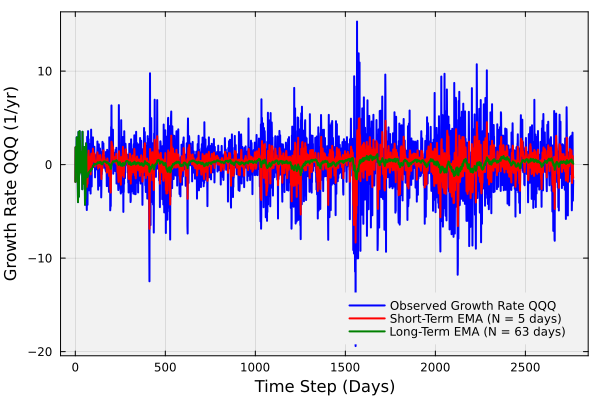

In [ ]:
let

    # Plot observed growth rate and both EMA smoothed versions
    # Shows how different window sizes capture different temporal patterns
    
    ema_data = EMA_growth_rate_data[my_ticker]; # retrieve stored EMA series
    i = findfirst(==(my_ticker), list_of_tickers); # ticker position
    gᵢ = G[:, i]; # actual growth rate time series

    # Base plot: raw observed growth rates
    plot(gᵢ, label="Observed Growth Rate $(my_ticker)", color=:blue, linewidth=2,
         xlabel = "Time Step (Days)", ylabel = "Growth Rate $(my_ticker) (1/yr)");

    # Overlay short-term EMA: quick response but noisier
    short_term_EMA = ema_data.short_term_EMA;
    plot!(short_term_EMA[:,1], short_term_EMA[:,2], label="Short-Term EMA (N = $(Nₒ) days)", color=:red, linewidth=2);

    # Overlay long-term EMA: smooth trend following with lag
    long_term_EMA = ema_data.long_term_EMA;
    plot!(long_term_EMA[:,1], long_term_EMA[:,2], label="Long-Term EMA (N = $(N₁) days)", color=:green, linewidth=2);

    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

## Task 2: Kernel Regression for Ticker Growth Rates
In this task, we implement kernel regression to predict target ticker growth rates using SPY as a predictor.

> Kernel regression is a memory-based method that predicts $\hat{y}(\mathbf{z}) = \sum_{i=1}^{n} \alpha_i k(\mathbf{z}, \mathbf{x}_i)$, where weights $\alpha_i$ solve $(\mathbf{K}+\lambda\mathbf{I})\boldsymbol{\alpha} = \mathbf{y}$ with kernel matrix $K_{ij} = k(\mathbf{x}_i, \mathbf{x}_j)$, regularization $\lambda \geq 0$, and observed responses $\mathbf{y}$.

Let's create our dataset for kernel regression. The predictor variable will be the growth rate of the SPY ETF and two EMA of SPY (short and long term moving averages), and the response variable will be the growth rate of our target ticker. 

> __Building the design matrix:__
>
> Extract SPY's raw growth rates and both short- and long-term EMAs to form a [intercept, SPY, EMA_short, EMA_long] feature matrix. Target variable is the selected ticker's growth rate. We then standardize features (columns 2-4) to zero mean and unit variance for kernel conditioning.

We will store the (augmented) predictor variables in the `X̂::Array{Float64,2}` variable and the response variable in the `y::Array{Float64,1}` variable. We've z-score centered the predictor data matrix, where the means and standard deviations used for z-score centering are stored in the `μ::Array{Float64,1}` and `σ::Array{Float64,1}` variables, respectively.

In [ ]:
X̂, y, μ, σ, X̂_raw = let 

    # Build predictor features using SPY (market-wide) indicators
    basis_ticker = "SPY"
    i = findfirst(==(basis_ticker), list_of_tickers); # locate SPY in ticker list
    g_basis = G[:, i]; # SPY growth rates (raw returns)
    gₒ = EMA_growth_rate_data[basis_ticker].short_term_EMA[:,2]; # short-term EMA: responsive to recent changes
    g₁ = EMA_growth_rate_data[basis_ticker].long_term_EMA[:,2]; # long-term EMA: captures trend
    number_of_time_steps = length(g_basis); # total data points

    # Construct augmented feature matrix: [intercept | SPY | EMA_short | EMA_long]
    ones_vector = ones(number_of_time_steps);
    X̂_raw = hcat(ones_vector, g_basis, gₒ, g₁); # column 1 = intercept, cols 2-4 = features
    y = G[:, findfirst(==(my_ticker), list_of_tickers)]; # target: growth rate of selected ticker

    # Standardize features (columns 2:end) to unit variance; improves kernel conditioning
    μ = mean(X̂_raw[:, 2:end], dims=1); # feature means
    σ = std(X̂_raw[:, 2:end], dims=1; corrected=false); # feature standard deviations
    σ = max.(σ, 1.0e-8); # guard against zero variance

    X̂ = copy(X̂_raw); # duplicate matrix
    X̂[:, 2:end] = (X̂_raw[:, 2:end] .- μ) ./ σ; # z-score: X_std = (X - μ) / σ
    
    (X̂, y, μ, σ, X̂_raw); # return: standardized matrix, target, normalization parameters, raw matrix
end

([1.0 -0.32203848731560875 -0.6467026656829501 -2.003006705144027; 1.0 0.3620861270480972 0.7255959374207943 2.247467849848752; … ; 1.0 -1.1977129266314854 -1.1174917102983697 -0.27871272140259123; 1.0 -0.47861905507361496 -1.065258010503591 -0.36299806380392885], [-1.8370782614029393, 1.8582229796323604, 0.8197987971493579, -0.5638856786335223, -0.28661699033135296, -0.8060098104223028, 1.3979927040931297, 2.9178083215335393, 0.4007621721868238, -0.7446580118251208  …  -0.19468356718772967, -4.8864099323268055, -3.909786827009694, -0.20892283486561233, 1.8309873122114917, 3.423698952116346, 0.7704422339821627, -3.853029063007002, -2.3965628437583195, -1.6987442901685323], [0.10610026953971988 0.10686953673715098 0.10685194920229732], [2.1445891216142634 1.069130437409649 0.34517703536645433], [1.0 -0.5845399670984476 -0.5845399670984476 -0.5845399670984476; 1.0 0.8826262386945092 0.8826262386945092 0.8826262386945092; … ; 1.0 -2.462501843730946 -1.0878748642958018 0.010646718309634345

Next, we split the data into training and test sets. The training set estimates kernel regression weights $\mathbf{\alpha}$; the test set evaluates performance.

> __What is going on in this code block?__
>
> Fill me in

We return: `Xtr_raw` and `Xte_raw` (unstandardized train/test feature matrices), `Xtr` and `Xte` (standardized using training mean $\mu_{tr}$ and standard deviation $\sigma_{tr}$), `ytr` and `yte` (target growth rate vectors), and `idx_train`/`idx_test` (row indices for the split).

In [ ]:
Xtr_raw, Xte_raw, Xtr, Xte, ytr, yte, idx_train, idx_test, μ_tr, σ_tr = let

    # Random 80/20 train-test split with fixed seed for reproducibility
    train_frac = 0.8;
    n = size(X̂_raw, 1); # total samples
    n_train = floor(Int, train_frac * n); # 80% for training

    Random.seed!(1234); # ensure same split every run
    perm = randperm(n); # random permutation of row indices
    idx_train = perm[1:n_train]; # first 80% of permutation
    idx_test = perm[(n_train + 1):end]; # remaining 20% for testing

    # Extract train and test subsets (raw, unstandardized)
    Xtr_raw = X̂_raw[idx_train, :];
    Xte_raw = X̂_raw[idx_test, :];

    # Compute normalization parameters from TRAINING data only
    # This prevents data leakage: test set statistics don't influence training
    μ_tr = mean(Xtr_raw[:, 2:end], dims=1); # training feature means
    σ_tr = std(Xtr_raw[:, 2:end], dims=1; corrected=false); # training feature standard deviations
    σ_tr = max.(σ_tr, 1.0e-8); # numerical stability

    # Standardize both train and test using TRAINING statistics
    # This ensures consistent feature scaling across both sets
    Xtr = copy(Xtr_raw);
    Xte = copy(Xte_raw);
    Xtr[:, 2:end] = (Xtr_raw[:, 2:end] .- μ_tr) ./ σ_tr; # z-score training features
    Xte[:, 2:end] = (Xte_raw[:, 2:end] .- μ_tr) ./ σ_tr; # apply same scaling to test

    # Split target variable according to train/test indices
    ytr = y[idx_train]; # training targets
    yte = y[idx_test]; # test targets

    (Xtr_raw, Xte_raw, Xtr, Xte, ytr, yte, idx_train, idx_test, μ_tr, σ_tr)
end

([1.0 2.3137838704643046 0.6979718918329135 0.35405267396271295; 1.0 1.554935259192919 0.11619385246392816 -0.2877995375165101; … ; 1.0 -0.8766021364138665 -0.33619302855959143 0.11247808414186052; 1.0 -0.1282013977673602 0.25063481875760896 0.31695893068635145], [1.0 -1.0985364780572295 -0.050057480903830054 0.26238088433457496; 1.0 0.09209744994137294 0.6218678268366249 0.2385159258320872; … ; 1.0 -0.8702783309812024 0.17903029986936803 0.26198501956577874; 1.0 3.367969179209646 -0.18909010834758577 0.0587443018511648], [1.0 1.0092768386353037 0.5483636585380913 0.7341909495309051; 1.0 0.6603404493393144 0.005592243793520222 -1.1442607985491249; … ; 1.0 -0.4577374737917526 -0.4164633354980992 0.02719609553656682; 1.0 -0.11360526137030727 0.13101931139819406 0.6256319921040386], [1.0 -0.5597880892683652 -0.14951239287008217 0.46590328081703836; 1.0 -0.012306684363277101 0.4773621627259576 0.3960598305412475; … ; 1.0 -0.4548296397369637 0.06421567944737487 0.4647447386267189; 1.0 1.494

We will use these splits for the kernel regression evaluation steps.

### Training Check: Full Data
This is a **full-data check** (not the train/test split). Compute the kernel matrix `KM_full` and weight vector `α_full` using *all* observations, then verify the model can reconstruct a randomly selected point. 

> __What is going on in this code block?__
>
> First, lets compute the kernel matrix $\mathbf{K}$ **for the full dataset** (no split) using a kernel from the `KernelFunctions.jl` package. The kernel matrix $\mathbf{K}$ is a symmetric matrix where each entry $K_{ij}$ represents the similarity between the feature vectors of data points $i$ and $j$ in our augmented feature dataset $\hat{\mathbf{X}}$.

We save the full-data kernel matrix in the `KM_full::Array{Float64,2}` variable.

In [ ]:
KM_full = let
    
    # Compute full-data kernel matrix: measures similarity between all pairs of observations
    A = X̂; # standardized feature matrix
    number_of_time_steps = size(A, 1); # total data points
    
    # Allocate kernel matrix K where K[i,j] = k(x_i, x_j)
    # This matrix is symmetric: K[i,j] = K[j,i]
    K = Array{Float64,2}(undef, number_of_time_steps, number_of_time_steps);
    
    # Compute kernel values: for each pair (i,j), evaluate similarity k(x_i, x_j)
    # Using squared exponential (RBF) kernel with current length scale
    for i ∈ 1:number_of_time_steps
        for j ∈ 1:number_of_time_steps
            K[i,j] = k(A[i,:], A[j,:]); # kernel similarity between samples i and j
        end
    end

    K; # return the symmetric kernel matrix
end;

Now we compute the coefficient vector $\boldsymbol{\alpha}$ for the full dataset. We solve the regularized linear system $(\mathbf{K} + \lambda\mathbf{I})\boldsymbol{\alpha} = \mathbf{y}$ using a linear solver, which is numerically more stable than forming an explicit matrix inverse. The full-data coefficients are stored in `α_full`.

In [ ]:
α_full = let
    
    # Solve regularized linear system to find kernel regression weights
    # System: (K + λI)α = y
    # where K = kernel matrix, λ = regularization parameter, y = target vector
    K = KM_full; # symmetric kernel matrix
    y_vec = y; # target growth rate vector

    # Solve the linear system using \ operator (numerically stable LU or Cholesky decomposition)
    # Regularization λI adds diagonal term to improve conditioning and prevent overfitting
    α_full_vec = (Symmetric(K) + λ*I) \ y_vec; # coefficient vector α for kernel regression

    α_full_vec; # return the weight vector (one weight per training sample)
end

2766-element Vector{Float64}:
   -2.1673630847764707
    1.8570001919756909
 1630.4202152039281
    6.178492236797256
 -226.46118272427836
   -0.8057886150733407
    4.286730547328942
    2.9175165698765517
    2.2092807215607255
    0.5302596891955121
    5.448094238258992
   11.227354624132243
   -1.2945551663087602
    ⋮
  150.13005396251788
   45.95481577906059
 -203.53431729030552
   -4.214611603575069
   -3.590581586388306
   -0.21328494806684736
    1.8770106865932055
    1.6888097045817343
  -47.603578822344296
   -3.9763687325086714
   -2.737087273021185
   -1.1685444757882901

We save the predicted growth rate in the `ŷ::Float64` variable, and the actual growth rate in the `y_true::Float64` variable.

In [ ]:
ŷ, y_true = let

    # Verify full-data model: randomly select a point and check if model reconstructs it
    number_of_samples = size(X̂, 1); # total observations
    t = rand(1:number_of_samples); # random time index for verification
    zₜ = X̂[t,:]; # feature vector at that time
    
    # Get actual value for comparison
    y_true = y[t]; # actual growth rate at time t

    # Reconstruct prediction from all training samples via kernel
    # ŷ = Σⱼ αⱼ k(xⱼ, z_t): weighted sum of all training observations
    ŷ = 0.0; # initialize prediction accumulator
    for j ∈ 1:number_of_samples
        ŷ += α_full[j] * k(X̂[j,:], zₜ); # each sample j contributes weight α_j times similarity k(xⱼ, z_t)
    end
    
    # Return prediction and actual value for inspection
    (ŷ, y_true);
end

(4.544185931278993, 4.545418726543576)

### Can the model generalize to data it hasn't seen before?

The model fits training data, but does it generalize to unseen test data? We evaluate by computing training kernel matrices to fit $\boldsymbol{\alpha}$, then using test kernel matrices to generate predictions and comparing to actual test values.

> __Testing on unseen data:__
>
> Build kernel matrices relating training samples to training and test samples. Solve the regularized system on training data to obtain weights, then use those weights to predict on both training and test sets. Compare training and test errors—if training error is much smaller, the model is overfitting.

How does the model do?

In [ ]:
let

    # Evaluate kernel regression on the random 80/20 split from Task 2
    # Compares performance: does the model generalize from training to unseen test data?
    n_train = size(Xtr, 1); # number training samples
    n_test = size(Xte, 1); # number test samples

    # Build kernel matrices for train and test sets
    Ktr = [k(Xtr[i, :], Xtr[j, :]) for i in 1:n_train, j in 1:n_train]; # train-to-train similarity
    Kte = [k(Xte[i, :], Xtr[j, :]) for i in 1:n_test, j in 1:n_train]; # test-to-train similarity (used for prediction)

    # Solve regularized system on training data: (K + λI)α = y_train
    α_tr = (Symmetric(Ktr) + λ * I) \ ytr; # weight vector fitting training set

    # Generate predictions for both sets using fitted weights
    ŷ_tr = Ktr * α_tr; # predictions on training set (should have low error)
    ŷ_te = Kte * α_tr; # predictions on test set (reveals generalization)

    # Compute relative errors: ||residuals|| / ||target||
    rel_err_tr = norm(ŷ_tr - ytr) / norm(ytr); # training error
    rel_err_te = norm(ŷ_te - yte) / norm(yte); # test error (generalization measure)

    # Return error pair for inspection
    (rel_err_tr, rel_err_te)
end

(0.0205928186056178, 1.0702935344801994)

We expect training error to be smaller than test error because the model fits the training data directly.

### Rolling Window Evaluation

To evaluate generalization under regime changes, we use a rolling window: train on fixed historical windows, then test on subsequent blocks. This is more realistic for time series than a random split.

> __What is going on in this code block?__
>
> We slide a fixed training window forward, standardize features using the training statistics, build kernel matrices for train and test, solve for the training weights, and compute relative errors. Each window's indices and errors are stored in a table for comparison.

If we change the way we split the data, do we get different results? Let's find out by running the code block above.

In [ ]:
let
    # Rolling window time-series evaluation: train on historical data, test on future data
    n = size(X̂_raw, 1); # total number of time steps
    train_window = 252;   # 1 trading year of history for fitting
    test_horizon = 63;    # ~1 quarter ahead for evaluation
    step = 63;            # slide forward by one quarter (non-overlapping test windows)
    df = DataFrame(); # store results for each window

    if n < train_window + test_horizon
        error("Not enough data for the requested windows.")
    end

    # Generate starting indices for rolling windows
    starts = 1:step:(n - train_window - test_horizon + 1); # valid start positions
    rel_err_tr = Float64[];
    rel_err_te = Float64[];

    for (w, s) in enumerate(starts) # w = window iteration counter, s = starting index
        
        # Define contiguous historical and forward-looking windows
        tr = s:(s + train_window - 1); # training window: 252 days
        te = (s + train_window):(s + train_window + test_horizon - 1); # test window: 63 days after training ends

        # Extract features and targets for this window
        Xtr_raw = X̂_raw[tr, :];
        Xte_raw = X̂_raw[te, :];

        # Compute training statistics and standardize both sets
        # (prevents look-ahead bias in feature normalization)
        μ_tr = mean(Xtr_raw[:, 2:end], dims=1); # mean from historical window
        σ_tr = std(Xtr_raw[:, 2:end], dims=1; corrected=false);
        σ_tr = max.(σ_tr, 1.0e-8);

        Xtr = copy(Xtr_raw);
        Xte = copy(Xte_raw);
        Xtr[:, 2:end] = (Xtr_raw[:, 2:end] .- μ_tr) ./ σ_tr; # standardize historical data
        Xte[:, 2:end] = (Xte_raw[:, 2:end] .- μ_tr) ./ σ_tr; # apply same transform to future data

        ytr = y[tr]; # historical targets
        yte = y[te]; # future targets

        # Build kernel matrices: train (train-to-train) and test (test-to-train)
        # Kte relates future observations back to historical training samples
        Ktr = [k(Xtr[i, :], Xtr[j, :]) for i in 1:train_window, j in 1:train_window];
        Kte = [k(Xte[i, :], Xtr[j, :]) for i in 1:test_horizon, j in 1:train_window];

        # Solve regularized system on historical data and evaluate on future data
        α_tr = (Symmetric(Ktr) + λ * I) \ ytr; # fit kernel regression weights to history
        ŷ_tr = Ktr * α_tr; # predictions on training set
        ŷ_te = Kte * α_tr; # predictions on test set (forward-looking)

        # Compute relative errors: ratio of residual norm to target norm
        tr_err = norm(ŷ_tr - ytr) / norm(ytr);
        te_err = norm(ŷ_te - yte) / norm(yte);

        push!(rel_err_tr, tr_err);
        push!(rel_err_te, te_err);

        # Record window metadata and performance
        row_df = (
            window = w, # iteration counter
            train_start = first(tr), # first training sample index
            train_end = last(tr), # last training sample index
            test_start = first(te), # first test sample index
            test_end = last(te), # last test sample index
            rel_err_tr = tr_err, # training error
            rel_err_te = te_err # test error
        );

        push!(df, row_df);
    end

    # Display results as formatted table
    pretty_table(
        df;
        backend = :text,
        fit_table_in_display_horizontally = false,
        fit_table_in_display_vertically = false,
        table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 -------- ------------- ----------- ------------ ---------- ------------- ------------
  window   train_start   train_end   test_start   test_end    rel_err_tr   rel_err_te 
   Int64         Int64       Int64        Int64      Int64       Float64      Float64 
 -------- ------------- ----------- ------------ ---------- ------------- ------------
       1             1         252          253        315   0.000158483     0.920287
       2            64         315          316        378    9.99057e-5     0.927083
       3           127         378          379        441    9.94281e-5     0.991594
       4           190         441          442        504   0.000113971     0.940274
       5           253         504          505        567    0.00011079     0.988482
       6           316         567          568        630   0.000114056     0.945706
       7           379         630          631        693   0.000102579     0.978825
       8           442         693          694   

___

## Task 3: Hyperparameter Search

In this task, we'll perform a hyperparameter search to find the best kernel length scale $\ell$ and ridge regularization parameter $\lambda$ for our kernel regression model. The grid search varies kernel length scale $\ell$ and ridge $\lambda$ to find a better train/test tradeoff. We'll use the random 80/20 split created in Task 2 (and its training statistics).



> __What is going on in this code block?__
>
> We loop over a grid of length scales and regularization values, build the kernel matrices, solve for the training weights, and compute train and test errors. The results are sorted by test error and displayed as a ranked table.

In [ ]:
let

    # Grid search over kernel length scale (ℓ) and regularization strength (λ)
    # Length scale controls how nearby points influence predictions (local influence radius)
    # Regularization controls overfitting tendency
    n_train = size(Xtr, 1); # number training samples
    n_test = size(Xte, 1); # number test samples
    ℓ_grid = [0.05, 0.1, 0.2, 0.3, 0.5]; # kernel length scales: smaller = very local, larger = global
    λ_grid = [1e-4, 1e-3, 1e-2, 1e-1, 1.0]; # regularization: smaller = less penalty, larger = more
    results = Vector{NamedTuple}(); # accumulate (ℓ, λ, train error, test error) tuples
    df = DataFrame(); # final ranked table

    # Iterate through all 5×5=25 combinations of hyperparameters
    for ℓ in ℓ_grid, λ in λ_grid
        # Create kernel function with current length scale
        k_local = with_lengthscale(SqExponentialKernel(), ℓ);

        # Build kernel matrices: evaluate similarity between all pairs
        Ktr = [k_local(Xtr[i, :], Xtr[j, :]) for i in 1:n_train, j in 1:n_train]; # train-to-train
        Kte = [k_local(Xte[i, :], Xtr[j, :]) for i in 1:n_test, j in 1:n_train]; # test-to-train

        # Fit and predict: solve (K + λI)α = y, then ŷ = K*α
        α_tr = (Symmetric(Ktr) + λ * I) \ ytr; # solve regularized system for weights
        ŷ_tr = Ktr * α_tr; # predictions on training data
        ŷ_te = Kte * α_tr; # predictions on test data

        # Evaluate model: relative errors measure prediction accuracy
        rel_err_tr = norm(ŷ_tr - ytr) / norm(ytr); # training error
        rel_err_te = norm(ŷ_te - yte) / norm(yte); # test error (generalization)

        # Store this hyperparameter combination's performance
        push!(results, (ell=ℓ, lambda=λ, rel_err_tr=rel_err_tr, rel_err_te=rel_err_te));
    end

    # Sort by test error: lower is better (better generalization)
    results_sorted = sort(results, by = r -> r.rel_err_te);

    # Convert sorted results into DataFrame with ranking
    for i ∈ eachindex(results_sorted)
        r = results_sorted[i];
        row_df = (
            rank = i, # best=1, worst=25
            length_scale = r.ell,
            lambda = r.lambda,
            rel_err_tr = r.rel_err_tr, # fit quality on training data
            rel_err_te = r.rel_err_te # generalization quality on test data
        );
        push!(df, row_df);
    end

    # Display ranked hyperparameter results
    pretty_table(
        df;
        backend = :text,
        fit_table_in_display_horizontally = false,
        fit_table_in_display_vertically = false,
        table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 ------- --------- --------- ------------- ------------
   rank       ell    lambda    rel_err_tr   rel_err_te 
  Int64   Float64   Float64       Float64      Float64 
 ------- --------- --------- ------------- ------------
      1       0.5       0.1      0.319736     0.504767
      2       0.5       1.0      0.409045     0.515415
      3       0.5      0.01      0.299044     0.550282
      4       0.3       0.1      0.278756     0.605583
      5       0.3       1.0      0.417765     0.610621
      6       0.3      0.01      0.244916     0.653133
      7       0.2       0.1      0.232252     0.691464
      8       0.2       1.0      0.432725     0.702199
      9       0.5     0.001      0.283923     0.717149
     10       0.2      0.01      0.186427     0.729802
     11       0.3     0.001      0.218586      0.79368
     12       0.1       0.1      0.146324     0.832723
     13       0.1      0.01      0.078699     0.853624
     14       0.1       1.0       0.46487     0.856829
     1

Use the table to identify the length scale and regularization with the lowest test error.

## Summary

This lab builds a kernel regression model for ticker growth rates using SPY features and EMA signals.



**Key Takeaways**

* **Feature construction:** Use SPY growth rates and EMA signals to form predictors for the target ticker.

* **Kernel fitting:** Compute kernel matrices, solve the regularized system, and generate predictions.

* **Evaluation workflow:** Compare random split, rolling window, and grid search results to assess generalization.



These steps provide a baseline for exploring alternative kernels and features in later labs.